# Laboratorio 1

## Integrantes: Esteicy AAA, Carlos Morales y Cristopher McGuinness

### Se importan las bibliotecas:

In [157]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from pydub import AudioSegment

### Para generar y aplicar enventanado de Hamming

In [158]:
def get_window(type, length):
    window = list()
    if type == 'rectangular':
        for i in range(0, length):
            window.append(1)
    elif type == 'hamming':
        a = 0.53836
        b = 0.46164
        for i in range(0, length):
            window.append(a - b * np.cos(
                (2 * np.pi * i)/(length - 1)))
    return window

def apply_window(signal, window):
    windowed = list()
    for idx, sample in enumerate(signal):
        windowed.append(sample * window[idx])
    return windowed

### Cierra todas las figuras

In [159]:
plt.close('all')

### Se obtiene la señal y el ruido, además se les aplica enventanado de Hamming

In [160]:
audio = AudioSegment.from_file("ruido2.wav")
signal_ = np.array(audio.get_array_of_samples())
window = get_window('hamming', len(signal_))
signal = apply_window(signal_, window)

In [161]:
silencio = AudioSegment.from_file("silencio.wav")
ruido_ = np.array(silencio.get_array_of_samples())
ventana = get_window('hamming', len(ruido_))
ruido = apply_window(ruido_, ventana)

### Para generar y aplicar enventanado de Hamming

In [162]:
frame_rate = audio.frame_rate
time = np.arange(len(signal)) / float(frame_rate)
bin_size = 1024
num_bins = len(signal) // bin_size
bins = np.array_split(signal, num_bins)

In [163]:
fft_bins = [fft(bin) for bin in bins]
max_size = max([len(bin) for bin in fft_bins])
fft_bins_padded = [np.pad(bin, (0, max_size - len(bin)), 'constant') for bin in fft_bins]
fft_sum = np.sum(fft_bins_padded, axis=0)
frequency = np.fft.fftfreq(max_size, d=1.0/frame_rate)

### Lo mismo para el ruido

In [164]:
frame_rate_ = silencio.frame_rate
time_ = np.arange(len(ruido)) / float(frame_rate_)
bin_size_ = 1024
num_bins_ = len(ruido) // bin_size_
bins_ = np.array_split(ruido, num_bins_)

In [165]:
fft_bins_ = [fft(bin) for bin in bins_]
max_size_ = max([len(bin) for bin in fft_bins_])
fft_bins_padded_ = [np.pad(bin, (0, max_size_ - len(bin)), 'constant') for bin in fft_bins_]
fft_sum_ = np.sum(fft_bins_padded_, axis=0)
frequency_ = np.fft.fftfreq(max_size_, d=1.0/frame_rate_)

### Graficas

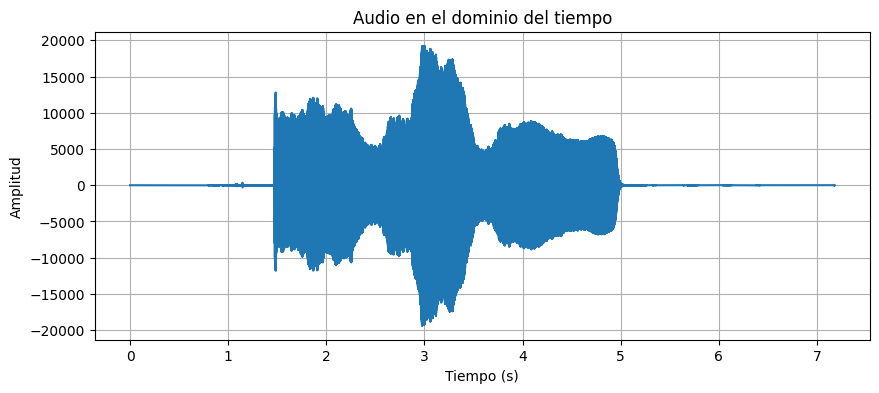

In [166]:
plt.figure(figsize=(10, 4))
plt.plot(time, signal)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Audio en el dominio del tiempo')
plt.grid()

Text(0.5, 1.0, 'Summed FFT of Audio Signal (Semilog)')

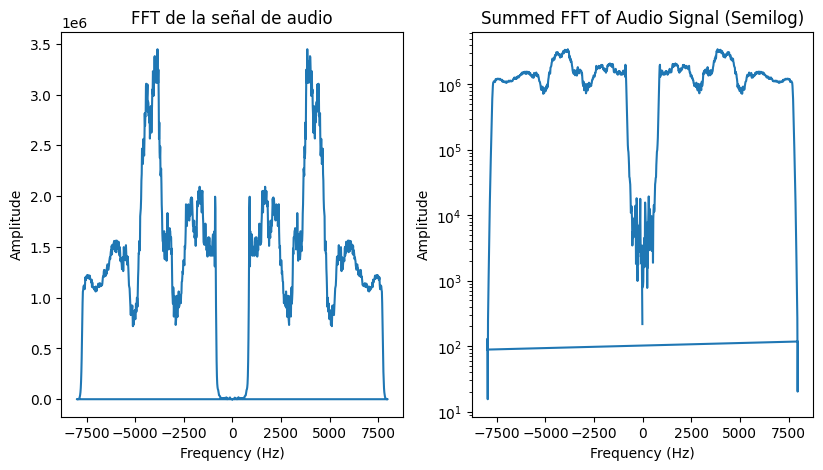

In [167]:
plt.figure(figsize=(15, 5))

# Plot 1: FFT of Audio Signal
plt.subplot(131)
plt.plot(frequency, np.abs(fft_sum))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT de la señal de audio')

# Plot 2: Summed FFT using stem on a semilogarithmic scale
plt.subplot(132)
plt.plot(frequency, np.abs(fft_sum))
plt.semilogy()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Summed FFT of Audio Signal (Semilog)')

# # Plot 3: Normalized FFT using stem on a semilogarithmic scale
# plt.subplot(133)
# plt.plot(frequency, np.abs(fft_sum) / np.abs(fft_sum))
# plt.semilogy()
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.title('Normalizada')

# plt.tight_layout()

### Espectro de potencia de la señal

Text(0, 0.5, 'Power Spectral Density')

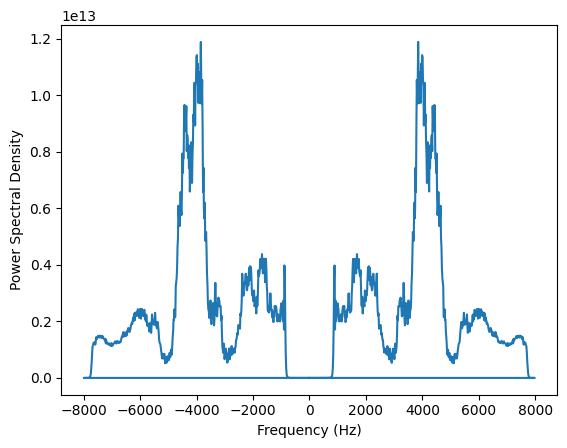

In [168]:
power_spectrum = np.abs(fft_sum)**2
plt.figure()
plt.plot(frequency, power_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')

Text(0, 0.5, 'Power Spectral Density')

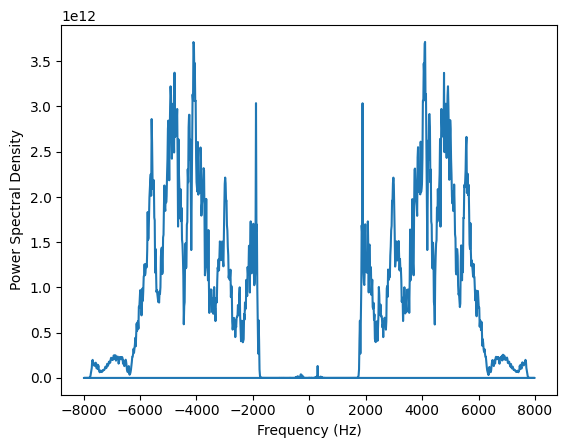

In [169]:
power_spectrum_ruido = np.abs(fft_sum_)**2

N = len(power_spectrum_ruido)
new_frequency = np.fft.fftfreq(N, d=1.0/silencio.frame_rate)

plt.figure()
plt.plot(new_frequency, power_spectrum_ruido)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')

In [170]:
plt.show()

## Filtro paso bajos con fc = 5kHz

In [171]:
from scipy import signal

def low_pass_filter(input_signal, cutoff=5000, fs=44100, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.filtfilt(b, a, input_signal)
    return filtered_signal


### Aplicando filtro

In [172]:
filtered_power_spectrum = low_pass_filter(power_spectrum)
filtered_power_spectrum_ruido = low_pass_filter(power_spectrum_ruido)

#### Graficando

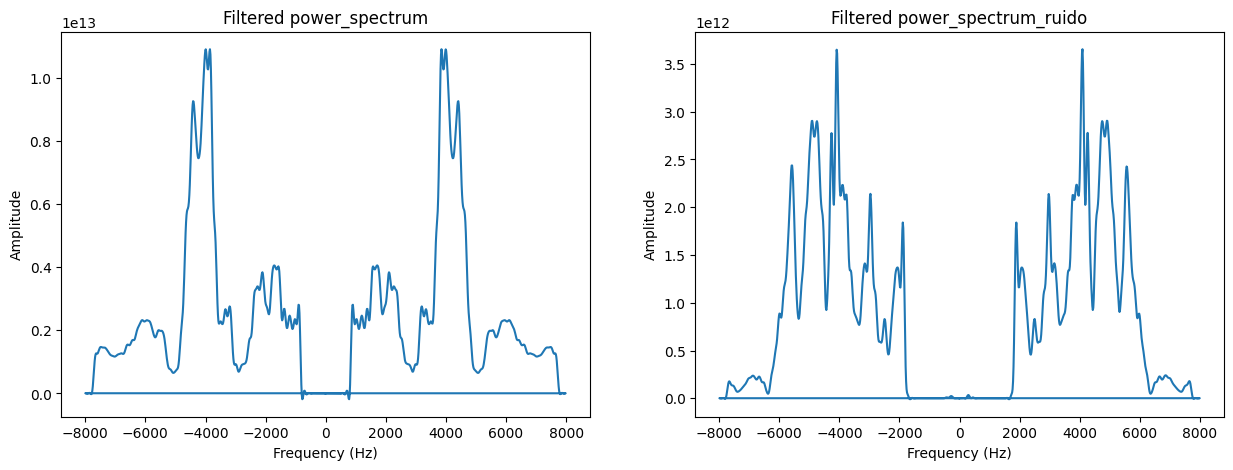

In [173]:

N = len(filtered_power_spectrum_ruido)
new_frequency = np.fft.fftfreq(N, d=1.0/silencio.frame_rate)

plt.figure(figsize=(15, 5))

# Plot 1: Filtered power_spectrum
plt.subplot(121)
plt.plot(frequency, filtered_power_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Filtered power_spectrum')

# Plot 2: Filtered power_spectrum_ruido
plt.subplot(122)
plt.plot(new_frequency, filtered_power_spectrum_ruido)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Filtered power_spectrum_ruido')

plt.show()


### Calculo de potencia total

In [174]:
potencia_total_señal = 20*np.log10(sum(filtered_power_spectrum))
potencia_total_ruido = 20*np.log10(sum(filtered_power_spectrum_ruido))

In [175]:
SNR= potencia_total_señal/potencia_total_ruido
print(SNR)

1.0309301670931996


## Usando referencia de senoidal de 1kHz

In [176]:
audio = AudioSegment.from_file("senoidal_1khz.m4a")
signal_ = np.array(audio.get_array_of_samples())
window = get_window('hamming', len(signal_))
signal = apply_window(signal_, window)

frame_rate = audio.frame_rate
time = np.arange(len(signal)) / float(frame_rate)
bin_size = 1024
num_bins = len(signal) // bin_size
bins = np.array_split(signal, num_bins)

fft_bins = [fft(bin) for bin in bins]
max_size = max([len(bin) for bin in fft_bins])
fft_bins_padded = [np.pad(bin, (0, max_size - len(bin)), 'constant') for bin in fft_bins]
fft_sum = np.sum(fft_bins_padded, axis=0)
frequency = np.fft.fftfreq(max_size, d=1.0/frame_rate)

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado

In [ ]:
power_spectrum = np.abs(fft_sum)**2
potencia_1khz = 20*np.log10(sum(power_spectrum))

In [ ]:
SNR= potencia_1khz/potencia_total_ruido
print(SNR)

0.9093552898202558
